# Preprocessing

1. Load data and SCB classifications to assign one final classification for each doc. Appraoches for now:
    - Get finest level
    - Define which level of classification is used
2. Normalise text


### Imports

In [82]:
import pandas as pd
import numpy as np

#NLTK
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evaengel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load SBC classifications

In [48]:
# Load SCB classifications & Preprocess
classifications = pd.read_excel('../data/SCB_classifications_raw.xlsx',  index_col=0)

# Lower and remove whitespace characters at the left and right ends
classifications = classifications.apply(lambda x: x.str.strip().str.lower())

# classifications.to_excel('../data/SCB_classifications.xlsx')  

In [49]:
# classifications = pd.read_excel('../data/SCB_classifications.xlsx',  index_col=0)

In [50]:
classifications

,Label Sv,Label En
1,naturvetenskap,natural sciences
101,matematik,mathematics
10101,matematisk analys,mathematical analysis
10102,geometri,geometry
10103,algebra och logik,algebra and logic
...,...,...
605,annan humaniora,other humanities
60501,antikvetenskap,classical archaeology and ancient history
60502,kulturstudier,cultural studies
60503,etnologi,ethnology


### Load data

In [62]:
# Load  data
data = pd.read_excel('../data/Finansierade projekt.xlsx')


# Output first five rows
print(data.shape)
data.head(1)

/Users/evaengel/comparison_NLP_classification_models/.venv/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


(7343, 13)


,Project ID,Title Sv,Title En,Description,Description En,Open Date,Close Date,Budget of Project,Research fields,Financier,Receive org,Project leader,Project url
0,1,"Judith Jack Halberstam, Columbia University, N...","Judith Jack Halberstam, Columbia University, N...",NaN,"Jack Halberstam (Legal name Judith, legal gend...",2022-01-01T23:59:59Z,2022-12-31T23:59:59Z,1695027,"social sciences , Humanities and the Arts , So...",Swedish Research Council,Lund University,"Esteban Arboix, Jens Rydström, Stig Wall, Jens...",https://www.ymner.com/sv/funded-projects/judit...


In [63]:
data = data[['Title En','Description En','Research fields']]

data = data[data['Research fields'].notna()] 
data = data[data['Research fields'] != 'Unclassified']

# For now delete missing english text
data = data[data['Description En'].notna()] 

data = data[data['Title En'].notna()] 

# Get unique classification

In [64]:
def get_classification_id(data_classifications: str):
    
    research_fields = data_classifications.split(', ')   #TODO: need to take care of single classifications that contain comma

    research_fields = list({x.lower().strip() for x in research_fields if x})

    research_mapping = dict()

    for field in research_fields:
        classification_id = classifications.index[classifications['Label En'] == field][0]
        research_mapping[classification_id] = field

    return research_mapping

In [65]:
def get_classification_for_specific_level(data_classification: str, nof_digits = 1):
    research_mapping = get_classification_id(data_classification)
    # Choose one value from the classification level of nof_digits digits
    for key, value in research_mapping.items():
        if len(str(key)) == nof_digits:
            return value
        else:
            print(f"No matching classification found for {data_classification}.")

In [66]:
get_classification_for_specific_level(nof_digits = 1, data_classification = data['Research fields'][0])

'social sciences'

In [67]:
data['Research fields'] = data['Research fields'].apply(lambda x: get_classification_for_specific_level(x))

In [68]:
data['Research fields']

0                   social sciences
1                  natural sciences
2        engineering and technology
3           humanities and the arts
4        engineering and technology
                   ...             
7337    medical and health sciences
7338                social sciences
7339                social sciences
7340        humanities and the arts
7341        humanities and the arts
Name: Research fields, Length: 7143, dtype: object

In [71]:
data

,Title En,Description En,Research fields
0,"Judith Jack Halberstam, Columbia University, N...","Jack Halberstam (Legal name Judith, legal gend...",social sciences
1,"Nomination of Professor Martin Shepperd, Brune...","Professor Martin John Shepperd, PhD, Dept. of...",natural sciences
2,Characterisation and effects of micro and nano...,Starting with the recent development of new ex...,engineering and technology
3,Moral Vagueness in a Mind-Independent World,The main objective of the project is to show t...,humanities and the arts
4,Bearbetning av organosolvfraktioner för funkti...,"The global demand for renewable, degradable an...",engineering and technology
...,...,...,...
7337,Spatial Omics Enable Improved Pathophysiology-...,We propose an innovative interdisciplinary res...,medical and health sciences
7338,A New Interdisciplinary Framework for Studying...,The program aims to establish a bold interdisc...,social sciences
7339,SweDigArch – The Swedish National Infrastructu...,SweDigArch will construct and run the Swedish ...,social sciences
7340,Design after progress: reimagining design hist...,Design’s ties to industrialisation and progres...,humanities and the arts


In [70]:
data['Description En'] = data['Description En'].apply(lambda x: x.replace('Purpose and goal: ','' ))

# Preprocess data

1)RegexpTokenizer - This helps us to filter our data .Since we don't want our text to have html tags and punctuation marks .

2)Stop Words - Some words like 'the','a','not' are very frequent in our language.

3)Stemming - In order to simplify our text we will use stemming. For examaple running,runs,run after stemmming becomes run.This helps to compress our text .


In [72]:
tokenizer = RegexpTokenizer("[a-zA-Z@]+") # We only want words in text as punctuation and numbers are not helpful
ss = SnowballStemmer("english")

stop = stopwords.words('english') 

In [73]:
def clean_up(sentence):
    sentence  = tokenizer.tokenize(sentence) # Conerting in regualr expression
    sentence = [ss.stem(w) for w in sentence if w not in stop  ]  # Stemming and removing stop words
    
    return " ".join(sentence) # returning the sentence in the form of a string

In [74]:
clean_up('The delegation refuses to give up.')

'the deleg refus give'

In [75]:
data["Description En"] = data["Description En"].apply(clean_up)

In [47]:
data

,Title En,Description En,Research fields
0,"Judith Jack Halberstam, Columbia University, N...",jack halberstam legal name judith legal gender...,social sciences
1,"Nomination of Professor Martin Shepperd, Brune...",professor martin john shepperd phd dept comput...,natural sciences
2,Characterisation and effects of micro and nano...,purpos goal start recent develop new experimen...,engineering and technology
3,Moral Vagueness in a Mind-Independent World,purpos goal the main object project show centr...,humanities and the arts
4,Bearbetning av organosolvfraktioner för funkti...,purpos goal the global demand renew degrad sus...,engineering and technology
...,...,...,...
7337,Spatial Omics Enable Improved Pathophysiology-...,we propos innov interdisciplinari research env...,medical and health sciences
7338,A New Interdisciplinary Framework for Studying...,the program aim establish bold interdisciplina...,social sciences
7339,SweDigArch – The Swedish National Infrastructu...,swedigarch construct run swedish nation infras...,social sciences
7340,Design after progress: reimagining design hist...,design tie industrialis progress made possibl ...,humanities and the arts


In [79]:
data.to_csv('../data/utlysningar_preprocessed_stemming', index=False)


Matplotlib is building the font cache; this may take a moment.


<AxesSubplot: >

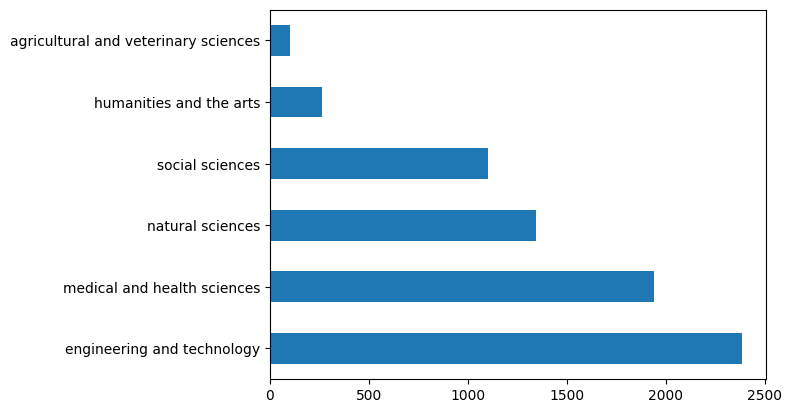

In [83]:
data['Research fields'].value_counts().plot(kind='barh')